In this code example, we'll compute the control forces required for a 2D quadrotor to follow a trajectory.

In [1]:
%pylab inline
from pylab import *

import matplotlib.animation
import scipy.integrate

rc("animation", html="html5")

import path_utils
path_utils.add_relative_to_current_source_file_path_to_sys_path("../../lib")

import flashlight.curve_utils       as curve_utils
import flashlight.interpolate_utils as interpolate_utils
import flashlight.quadrotor_2d      as quadrotor_2d
import flashlight.spline_utils      as spline_utils

Populating the interactive namespace from numpy and matplotlib
Initializing flashlight v0.0.1
flashlight.quadrotor_2d: Constructing sympy symbols...
flashlight.quadrotor_2d: Finished constructing sympy symbols (0.006 seconds).
flashlight.quadrotor_2d: Loading sympy modules...
flashlight.quadrotor_2d: Finished loading sympy modules (0.005 seconds).


/Users/mike/Code/GitHub/flashlight/code/lib/flashlight/transformations.py:1888: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


We begin by computing a trajectory almost exactly as in the previous example. Note that we sample our path more densely than in previous examples, because doing so will yield more accurate control forces.

In [2]:
T_y = matrix([0,1,2,3]).T.A
T_x = matrix([0,1,2,3]).T.A
T   = c_[T_y, T_x]
P_y = matrix([0,3,1,4]).T.A
P_x = matrix([0,3,7,10]).T.A
P   = c_[P_y, P_x]

num_samples = 200

C, T, sd = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P, T, degree=7, lamb=[0,0,0,1,0])
    
P_eval, T_eval, dT = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C, T, sd, num_samples=num_samples)

T_s = matrix([0.0,1.2,1.8,3.0]).T.A
P_s = matrix([0.0,0.3,0.7,1.0]).T.A

C_s, T_s, sd_s = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P_s, T_s, degree=7, lamb=[0,0,0,1,0])
    
P_s_eval, T_s_eval, dT_s = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C_s, T_s, sd_s, num_samples=num_samples)

Note that when we initially create our progress curve, we set the `t` keyframe values to be between 0 and 3. Doing so yields the overall shape of progress curve we want. But if we interpret the domain of the progress curve as time, a domain of [0,3] is not neccesarily the timing we want for our progress curve.

Here, we set the domain of our progress curve to be between 0 and 10. By changing the domain of our progress curve in this way, we can control the shape of our progress curve independently from its timing. Changing the domain of our progress curve in this way will be important in this example, because we will interpret the domain of our progress curve as time, and use it to compute quadrotor control forces. Executing our trajectory in 3 seconds would result in unreasonably large control forces, but executing our trajectory in 10 seconds yields well-behaved and reasonably bounded control forces.

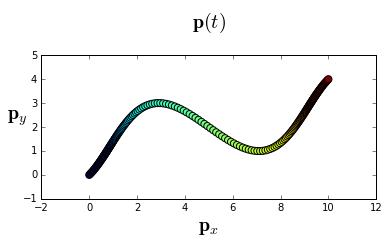

In [3]:
t = linspace(0.0,10.0,num_samples)
s_spline = P_s_eval

P_eval_spline, t_spline, P_eval_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s_spline)

figsize(6,6);
scatter(P_eval_spline[:,1], P_eval_spline[:,0], c=t, s=50);
gca().set_aspect("equal")
title("$\\mathbf{p}(t)$\n", fontsize=20);
ylabel("$\\mathbf{p}_y$", rotation="horizontal", fontsize=20); xlabel("$\\mathbf{p}_x$", fontsize=20);

Now that we have computed a (position) trajectory through space, we need to solve for the corresponding trajectory through the quadrotor's full state space, and its time derivatives. We solve for the state space trajectory and its time derivatives by calling `quadrotor_2d.compute_state_space_trajectory_and_derivatives`.

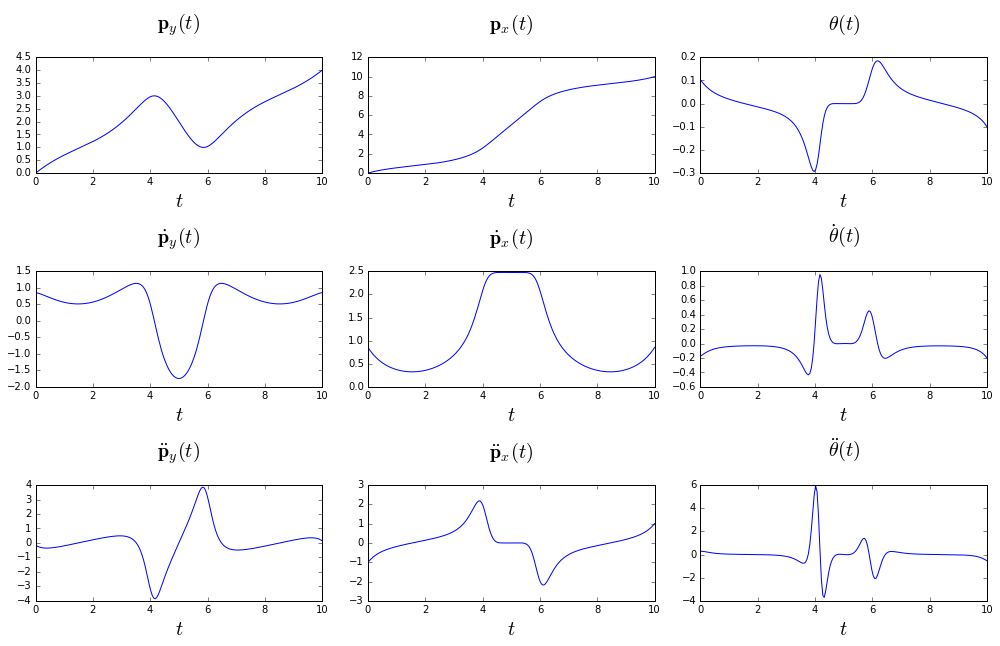

In [4]:
t_begin       = t[0]
t_end         = t[-1]
num_timesteps = num_samples

p  = P_eval_spline
dt = (t_end-t_begin) / (num_timesteps-1)

q_qdot_qdotdot = quadrotor_2d.compute_state_space_trajectory_and_derivatives(p, dt)

p, p_dot, p_dot_dot, theta, theta_dot, theta_dot_dot = q_qdot_qdotdot

figsize(14,9)

subplot(331); plot(t, p[:,0]);
title("$\\mathbf{p}_y(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(332); plot(t, p[:,1]);
title("$\\mathbf{p}_x(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(333); plot(t, theta);
title("$\\theta(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(334); plot(t, p_dot[:,0]);
title("$\\dot{\\mathbf{p}}_y(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(335); plot(t, p_dot[:,1]);
title("$\\dot{\\mathbf{p}}_x(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(336); plot(t, theta_dot);
title("$\\dot{\\theta}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(337); plot(t, p_dot_dot[:,0]);
title("$\\ddot{\\mathbf{p}}_y(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(338); plot(t, p_dot_dot[:,1]);
title("$\\ddot{\\mathbf{p}}_x(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(339); plot(t, theta_dot_dot);
title("$\\ddot{\\theta}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

gcf().tight_layout();

Next, we compute our control forces by passing in our state space trajectory and its time derivatives into the `quadrotor_2d.compute_control_trajectory` function. Note that this function assumes a unit mass, unit inertia matrix, unit arm length quadrotor. We'll see in later code examples how to modify these constant parameters. This function also assumes that we are working in kilograms, meters, seconds, radians, and Newtons. For more details on the dynamics model assumed by this function, see [1, 2].

#### References

[1] Niels Joubert, Mike Roberts, Anh Truong, Floraine Berthouzoz, Pat Hanrahan. An Interactive Tool for Designing Quadrotor Camera Shots. _ACM Transactions on Graphics 34(6) (SIGGRAPH Asia 2015)_.

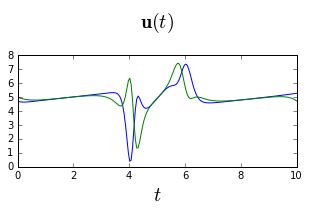

In [5]:
u = quadrotor_2d.compute_control_trajectory(q_qdot_qdotdot)

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

We can verify that our control forces are doing the right thing, by simulating a rigid body quadrotor under the influence of the control forces. We do this by calling `scipy.integrate.odeint` and passing in an initial state, as well as a callback function to compute the time derivative of the state. We can then animate our simulated trajectory and overlay it on top of our intended trajectory. Ideally the two trajectories should match exactly. To compute the time derivative of the state at a particular time `t`, we simply call the `quadrotor_2d.compute_x_dot` function, passing in the current state `x_t` and the current control force `u_t`.

The `interpolate_utils.interp1d_vector_wrt_scalar` function is similar to `scipy.interpolate.interp1d`, except it can handle functions that take as input a scalar and produce as output a vector. In this example, `interpolate_utils.interp1d_vector_wrt_scalar` returns a function `u_interp_func` that takes as input a `t` value and produces as output an interpolated `u` vector.

To draw our simulated trajectory, we call `quadrotor_2d.draw`. When we draw the simulated trajectory, we notice that it drifts away slightly from our intended trajectory. Because we compute control forces numerically (i.e., inexactly), and we perform numerical (i.e., inexact) integration in our simulation, and we don't apply any feedback control, a small amount of drift is expected. The amount of drift we observe decreases as the number of timesteps increases. For example, the drift is very small when `num_timesteps=1200` and `num_timesteps_sim=1200`. As we'll see in later code examples, a better way to eliminate simulation drift is to apply feedback control at each simulation step. Indeed, real quadrotors must constantly apply feedback control to follow an intended trajectory in the real world, due to unexpected disturbances from wind, model error, control error, etc.

In [6]:
x_nominal, q_nominal, qdot_nominal, qdotdot_nominal = \
    quadrotor_2d.pack_state_space_trajectory_and_derivatives(q_qdot_qdotdot)
    
x_0 = x_nominal[0]

def compute_x_dot(x_t, t):

    x_t     = matrix(x_t).T
    u_t     = u_interp_func(clip(t, t_begin, t_end))
    x_dot_t = quadrotor_2d.compute_x_dot(x_t, u_t).A1
    
    return x_dot_t

num_timesteps_sim = 200
t_sim             = linspace(t_begin, t_end, num_timesteps_sim)
u_interp_func     = interpolate_utils.interp1d_vector_wrt_scalar(t, u, kind="cubic")
x_sim             = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

figsize(9,4)
quadrotor_2d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, inline=True)